In [1]:
# Useful imports and setup
import sys
import os
# Necessary to import code from ../scripts/
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/scripts")
    
import warnings
warnings.filterwarnings("ignore")
    
import random
random.seed(0)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
import operator
from itertools import islice
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}')

from preprocessing import preprocess

%load_ext autoreload
%autoreload 2

results_path = '../results/'
clustering_method = 'spectral_clustering'
labels_path = '../labels/'
course = 'dsp_001'
norm= 'unit'

In [2]:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union


def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

### Jaccard Similarity

In [3]:
df_importance_shap = pd.read_csv(results_path+course+'/shap/'+clustering_method+'/'+norm+'/features_importance.csv')
df_importance_lime = pd.read_csv(results_path+course+'/lime/'+clustering_method+'/'+norm+'/features_importance.csv')

In [4]:
scaler = MinMaxScaler()
cols = df_importance_shap.columns
df_importance_shap = pd.DataFrame(scaler.fit_transform(df_importance_shap.T).T, columns=cols)

In [5]:
scaler = MinMaxScaler()
cols = df_importance_lime.columns
df_importance_lime = pd.DataFrame(scaler.fit_transform(df_importance_lime.T).T, columns=cols)

In [6]:
zero_data = np.zeros(shape=(len(df_importance_shap)+len(df_importance_shap), len(df_importance_shap)+len(df_importance_shap)))
cols = ['Lime'+str(i) for i in range(len(df_importance_lime))]
cols.extend(['Shap'+str(i) for i in range(len(df_importance_shap))])
d = pd.DataFrame(zero_data, columns=cols)

data = []
for i in range(len(df_importance_lime)):
    data.append(list({k: v for k, v in df_importance_lime.iloc[i].to_dict().items() if (not isinstance(v, float)) or (not math.isnan(v))}.keys()))

for i in range(len(df_importance_shap)):
    data.append(take(10, dict(sorted(df_importance_shap.iloc[i].to_dict().items(), key=operator.itemgetter(1),reverse=True))))

count = 0
for i in range(len(d)):
    for k,j in enumerate(d.columns):
        d[j][i] = jaccard(data[i], data[k])

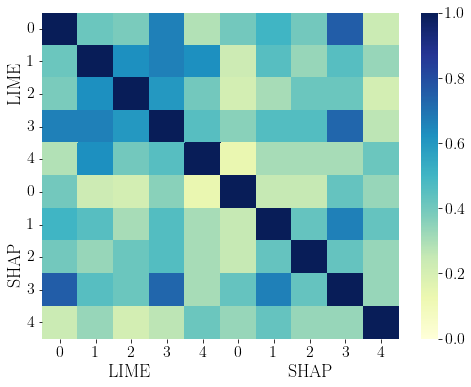

In [7]:
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d, vmin=0, vmax=1.0, fmt=".2f",ax=ax, cmap="YlGnBu", annot_kws={"size": 16})
l=list(np.arange(1,6+1))
g.set(xlabel='LIME \qquad \qquad \qquad \qquad SHAP', ylabel='SHAP \qquad \qquad \qquad \qquad LIME')
g.xaxis.get_label().set_fontsize(18)
g.yaxis.get_label().set_fontsize(18)
g.set_xticklabels(['0', '1', '2', '3', '4', '0', '1', '2', '3', '4'],rotation=0, fontsize=16)
g.set_yticklabels(['0', '1', '2', '3', '4', '0', '1', '2', '3', '4'],rotation=0, fontsize=16)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)


plt.savefig("../images/unit/jaccard_shap_lime.jpeg", bbox_inches='tight')

plt.show()

In [8]:
df_importance_interC3 = pd.read_csv(results_path+course+'/inter-c3/'+norm+'/features_importance.csv')

In [9]:
best10_shap_cluster0 = take(10, dict(sorted(df_importance_shap.iloc[0].to_dict().items(), key=operator.itemgetter(1),reverse=True)))
best10_lime_cluster0 = list({k: v for k, v in df_importance_lime.iloc[0].to_dict().items() if (not isinstance(v, float)) or (not math.isnan(v))}.keys())
best10_interc3_cluster5 = take(10, dict(sorted(df_importance_interC3.iloc[5].to_dict().items(), key=operator.itemgetter(1),reverse=True)))

In [10]:
zero_data = np.zeros((3, 3))
cols = ['LIME', 'SHAP', 'InterC3']
d = pd.DataFrame(zero_data, columns=cols)

data = [best10_lime_cluster0, best10_shap_cluster0, best10_interc3_cluster5]

count = 0
for i in range(len(d)):
    for k,j in enumerate(d.columns):
        d[j][i] = jaccard(data[i], data[k])

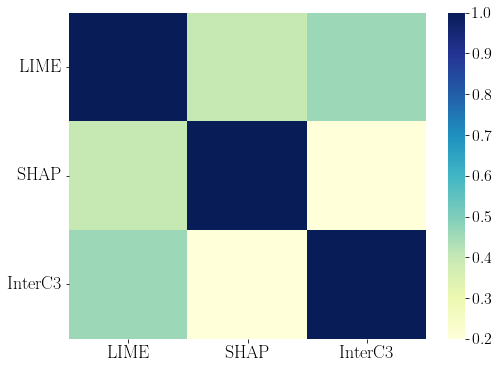

In [11]:
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d, vmin=0.2, vmax=1.0, fmt=".2f",ax=ax, cmap="YlGnBu")
l=list(np.arange(1,6+1))
g.xaxis.get_label().set_fontsize(16)
g.yaxis.get_label().set_fontsize(16)
g.set_xticklabels(['LIME', 'SHAP', 'InterC3'],rotation=0, fontsize=18)
g.set_yticklabels(['LIME', 'SHAP', 'InterC3'],rotation=0, fontsize=18)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)

plt.savefig("../images/unit/jaccard_shap_lime_interc3.jpeg", bbox_inches='tight')
plt.show()

### Spearman's Rank Correlation

In [12]:
df_importance = pd.concat([df_importance_shap, df_importance_lime])

In [13]:
df_importance = df_importance.fillna(0)

In [14]:
zero_data = np.zeros(shape=(len(df_importance_shap)+len(df_importance_shap), len(df_importance_shap)+len(df_importance_shap)))
cols = ['Lime'+str(i) for i in range(len(df_importance_lime))]
cols.extend(['Shap'+str(i) for i in range(len(df_importance_shap))])
d = pd.DataFrame(zero_data, columns=cols)

data = []
for i in range(len(df_importance_lime)):
    data.append(df_importance.iloc[i+len(df_importance_shap)])

for i in range(len(df_importance_shap)):
    data.append(df_importance.iloc[i])

count = 0
for i in range(len(d)):
    for k,j in enumerate(d.columns):
        d[j][i] = stats.spearmanr(data[i], data[k])[0]

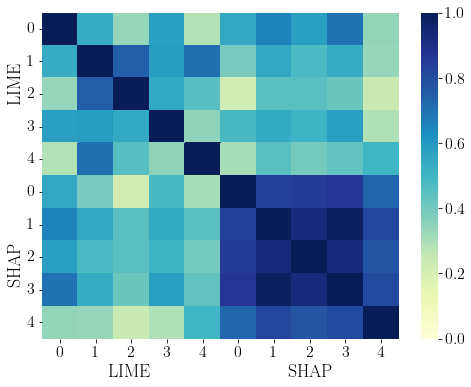

In [15]:
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d, vmin=0, vmax=1.0, fmt=".2f",ax=ax, cmap="YlGnBu")
l=list(np.arange(1,6+1))
g.set(xlabel='LIME \qquad \qquad \qquad \qquad  SHAP', ylabel='SHAP \qquad \qquad \qquad \qquad  LIME')
g.xaxis.get_label().set_fontsize(18)
g.yaxis.get_label().set_fontsize(18)
g.set_xticklabels(['0', '1', '2', '3', '4', '0', '1', '2', '3', '4'],rotation=0, fontsize=16)
g.set_yticklabels(['0', '1', '2', '3', '4', '0', '1', '2', '3', '4'],rotation=0, fontsize=16)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)


plt.savefig("../images/unit/spearman_shap_lime.jpeg", bbox_inches='tight')
plt.show()

In [16]:
df_importance = pd.concat([df_importance, df_importance_interC3])

In [17]:
df_importance = df_importance.fillna(0)

In [18]:
zero_data = np.zeros((3, 3))
cols = ['LIME', 'SHAP', 'InterC3']

d = pd.DataFrame(zero_data, columns=cols)

data = [df_importance.iloc[len(df_importance_shap)], df_importance.iloc[0], df_importance.iloc[2*len(df_importance_shap)+5]]

count = 0
for i in range(len(d)):
    for k,j in enumerate(d.columns):
        d[j][i] = stats.spearmanr(data[i], data[k])[0]

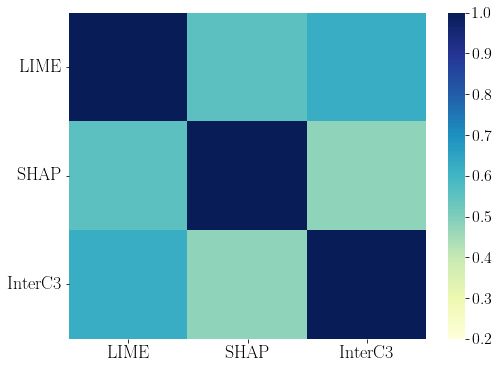

In [19]:
fig, ax = plt.subplots(figsize=(8, 6),facecolor='white')
g = sns.heatmap(d,vmin=0.2, vmax=1.0, fmt=".2f",ax=ax, cmap="YlGnBu")
l=list(np.arange(1,6+1))
g.xaxis.get_label().set_fontsize(18)
g.yaxis.get_label().set_fontsize(18)
g.set_xticklabels(['LIME', 'SHAP', 'InterC3'],rotation=0, fontsize=18)
g.set_yticklabels(['LIME', 'SHAP', 'InterC3'],rotation=0, fontsize=18)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)

plt.savefig("../images/unit/spearman_shap_lime_interc3.jpeg", bbox_inches='tight')
plt.show()

In [20]:
labels_cluster_path = labels_path + course + '/spectral_clustering/'
labels_masked = np.loadtxt(labels_cluster_path+'inter-c3/cluster_unit_norm_0.5_perc_0.4_gamma_0.6.txt', dtype=int)
labels_baseline = np.loadtxt(labels_cluster_path+'baseline_unit_norm_perc_0.4_gamma_0.6.txt', dtype=int)

In [21]:
similarity = {}
value = {}
for i in range(np.max(labels_masked)+1):
    masked = np.where(labels_masked == i)[0]
    max_similarity = 0
    idx_sim = -1
    for j in range(np.max(labels_baseline)+1):
        sim = jaccard(masked, np.where(labels_baseline == j)[0])
        if sim > max_similarity:
            max_similarity = sim
            idx_sim = j
    similarity[i] = idx_sim
    value[i] = max_similarity

In [22]:
similarity

{0: 4, 1: 2, 2: 3, 3: 3, 4: 1, 5: 0}

In [23]:
best10_lime_cluster1 = take(10, dict(sorted(df_importance_lime.iloc[1].to_dict().items(), key=operator.itemgetter(1),reverse=True)))
best10_lime_cluster2 = list({k: v for k, v in df_importance_lime.iloc[2].to_dict().items() if (not isinstance(v, float)) or (not math.isnan(v))}.keys())

In [24]:
value

{0: 0.5212557226945717,
 1: 0.4333120612635609,
 2: 0.37317073170731707,
 3: 0.35936546674801706,
 4: 0.6844368013757524,
 5: 0.7802547770700637}

In [25]:
best10_lime_cluster1

['content_alignment',
 'student_speed',
 'time_between_sessions std',
 'time_sessions sum',
 'regularity_peak_dayhour',
 'time_in__video sum',
 'weekly_prop_watched mean',
 'regularity_periodicity_m1',
 'delay_lecture',
 'time_in__problem sum']

In [26]:
best10_lime_cluster2

['student_speed',
 'time_between_sessions std',
 'time_sessions sum',
 'time_in__problem sum',
 'student_shape',
 'delay_lecture',
 'weekly_prop_replayed mean']

In [27]:
best10_interc3_cluster5

['total_clicks_Video.Load',
 'total_clicks_Video',
 'time_between_sessions std',
 'time_in__problem sum',
 'student_speed',
 'time_sessions sum',
 'time_in__video sum',
 'content_alignment']